In [21]:
# !pip install langgraph
# !pip install datetime
# !pip install browserbase
# !pip install langchain_ollama

In [22]:
import operator
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import Annotated, TypedDict, Sequence, Optional
from langchain_core.messages import BaseMessage, HumanMessage

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    input_obj: Optional[dict]
    flight_data: Optional[str]
    hotel_data: Optional[str]
    places_data: Optional[str]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="llama3.2", base_url="http://localhost:11434/v1/", api_key="NA", verbose=True)
visionllm = ChatOpenAI(model="gemma3:4b", base_url="http://localhost:11434/v1/", api_key="NA", verbose=True)

## User input Agent

In [23]:
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from datetime import datetime

def input_agent(state: State):
    current_date = datetime.today().strftime('%Y-%m-%d')
    
    input_prompt_template = ChatPromptTemplate.from_template("""
        Today is {current_date} and the user is currently in Abu Dhabi, extract the following information:\
    
        from_city: The user's current city.\
    
        to_city: The name of the city the user wants to travel to.\
    
        from_date: The date of departure. Answer in DD/MM/YYYY format, should not consider today as valid value.\
    
        to_date: The return date from that city. If not present, set a duration of 3 days from the departure date. Answer in DD/MM/YYYY format.Do not return none\
    
        budget: The amount of money the user is willing to spend on this trip.\

        currency: The currency mentioned by user\
    
        text: {text}
    
        Return ONLY a single, valid JSON object with the extracted data. Do not include ```json ``` markers or any other text before or after the JSON object.
    
        JSON structure:
        {{
            "from_city": "string",
            "to_city": "string",
            "from_date": "DD/MM/YYYY",
            "to_date": "DD/MM/YYYY",
            "budget": "string or number",
            "currency": "string"
        }}
    """)
    
    parsed_output = JsonOutputParser()
    last_message = state["messages"][-1]
    if hasattr(last_message, 'content'):
         input_text = last_message.content
    else:
         input_text = last_message

    chain = input_prompt_template | llm | parsed_output
    input_data = {
        "current_date": current_date,
        "text": input_text
    }

    extracted_data = chain.invoke(input_data)

    return { "input_obj": extracted_data }

## Flight details Agent

In [24]:
import os
import requests
import base64
import asyncio
import json
from browserbase import Browserbase
from playwright.async_api import async_playwright
from langchain.schema.runnable import RunnableSequence, RunnableLambda
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv

load_dotenv()

bb = Browserbase(api_key=os.environ["BROWSERBASE_API_KEY"])

def iata_code_fetch(state: State):
    iata_prompt = ChatPromptTemplate.from_template("""
        Extract the following information from following text:\

        from_city: IATA code for this city, if from_city is Abu Dhabi use AUH as from_city value\

        to_city: IATA code for this city, if to_city is Bombay use BOM as from_city value\
        
        city_1: {{from_city}}\
        city_2: {{to_city}}\

        Return only the JSON object below with the extracted data, Do not include ```json ``` markers or any other text before or after the JSON object.
        Ensure the output is a single, valid JSON object with keys: "from_city", "to_city".

        JSON structure:
        {{
            from_city: "string",
            to_city: "string"
        }}
    """)

    parsed_output = JsonOutputParser()
    chain = iata_prompt | llm | parsed_output
    input_data = {
        "from_city" : state["input_obj"].get("from_city"),
        "to_city": state["input_obj"].get("to_city")
    }
    
    extracted_data = chain.invoke(input_data)
    state["input_obj"]["from_city_code"] = extracted_data.get("from_city")
    state["input_obj"]["to_city_code"] = extracted_data.get("to_city")
    
    return state

async def take_screen_shot(state: State):
    input_data = state.get('input_obj', {})
    from_city = input_data.get('from_city_code')
    to_city = input_data.get('to_city_code')
    from_date = input_data.get('from_date')
    to_date = input_data.get('to_date')

    url = f"https://www.skyscanner.ae/transport/flights/{from_city}/{to_city}/{from_date}/{to_date}/?adultsv2=1&cabinclass=economy&childrenv2=&ref=home&rtn=1&preferdirects=false&outboundaltsenabled=false&inboundaltsenabled=false"
    mmt_url = f"https://ae.makemytrip.global/flight/search?tripType=O&itinerary={from_city}-{to_city}-{from_date}&paxType=A-1_C-0_I-0&cabinClass=E&sTime=1744478591908&forwardFlowRequired=true&cmp=SEM|D|GCCDF|G|Brand|B_M_MakeMyTrip_Variants|MakeMyTripFlight|RSA|686216215337&mpo=&semType=&intl=true"

    print("mmt_url", mmt_url)
    session = bb.sessions.create(project_id=os.environ["BROWSERBASE_PROJECT_ID"])

    browser = await async_playwright().start()
    browser = await browser.chromium.connect_over_cdp(session.connect_url)
    page = await browser.new_page()
    _ = await page.goto(mmt_url)
    await page.wait_for_selector(".listingCard", state="attached", timeout=50000)
    await page.screenshot(path="screenshot.png")
    await page.close()
    await browser.close()

    return state

def get_data_from_image(state: State):
    cont = {}
    try:
        with open("screenshot.png", "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

        specific_prompt = """From the content of this image, which displays a list of flight search results, extract the details for each flight and format them as a Markdown list. Each item in the list should represent a single flight with the following information (if present and clearly visible):
            - **Departure:** [departure_city] ([departure_time], [departure_date in DD/MM/YYYY format, inferring 2025 if year is missing])
            - **Arrival:** [arrival_city] ([arrival_time], [arrival_date in DD/MM/YYYY format, inferring 2025 if year is missing])
            - **Price:** [price including currency if visible]
            
            Separate each flight listing with a newline. If any piece of information is not clearly visible for a flight, omit that detail. If no discernible flight information is present in the image, return an empty string.
            
            Ensure the final output is a single Markdown list.
            """
        message = HumanMessage(
            content=[
                {"type": "text", "text": specific_prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{encoded_string}"},
                },
            ],
        )

        response = visionllm.invoke([message])
        cont = response.content
    except FileNotFoundError:
        print(f"Error: File not found at screenshot.png")
        cont = {"error": "Screenshot file not found"}
    except Exception as e:
        print(f"An error occurred: {e}")
        cont = {"error": str(e)}

    return { "flight_data": cont }

## hotel agent

In [25]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage

async def fetch_hotel_data(state):
    async with MultiServerMCPClient(
        {
            "airbnb": {
                "command": "npx",
                "args": ["-y", "@openbnb/mcp-server-airbnb", "--ignore-robots-txt"]
            }
        }
    ) as client:
        agent = create_react_agent(llm, client.get_tools())
        location = state["input_obj"].get("to_city")
        checkin = state["input_obj"].get("from_date")
        checkout = state["input_obj"].get("to_date")
        amount = state["input_obj"].get("budget")
        currency = state["input_obj"].get("currency")
        search_results = await agent.ainvoke({ "messages": f"i want to list of cheap hotels in this city {location} between dates {checkin} and {checkout} under {amount} {currency} give the output in markdown structure" })

        if isinstance(search_results, dict) and "messages" in search_results and isinstance(search_results["messages"], list) and search_results["messages"]:
            last_message = search_results["messages"][-1]
            if isinstance(last_message, AIMessage):
                return { "hotel_data": last_message.content }
            elif isinstance(last_message, dict) and "content" in last_message:
                return { "hotel_data": last_message["content"] }
            else:
                print("Last message is not an AIMessage and does not have 'content'.")
                return { "hotel_data": str(last_message) }
        else:
            print("Could not access the final response messages.")
            return { "hotel_data": str(search_results) }

## Places Agent

In [26]:
import requests
from typing import Any, Dict
import json


def fetch_places_data(state: Dict[str, Any]) -> Dict[str, Any]:
    url = "https://travel-guide-api-city-guide-top-places.p.rapidapi.com/check"
    querystring = {"noqueue": "1"}
    payload = {
        "region": state["input_obj"].get("to_city"),
        "language": "en",
        "interests": ["historical", "cultural", "food"]
    }
    headers = {
        "x-rapidapi-key": os.environ["RAPID_API_KEY"],
        "x-rapidapi-host": "travel-guide-api-city-guide-top-places.p.rapidapi.com",
        "Content-Type": "application/json"
    }

    response = requests.post(url, json=payload, headers=headers, params=querystring)
    response.raise_for_status()

    places_data = response.json()

    markdown_output = f"## Places to Visit in {state['input_obj'].get('to_city')}\n\n"

    if isinstance(places_data, dict) and "result" in places_data and isinstance(places_data["result"], list):
        for item in places_data["result"]:
            if isinstance(item, dict):
                name = item.get("name", "N/A")
                description = item.get("description", "No description available.")
                type = item.get("type", "N/A").capitalize()
                comments = item.get("comments", "No specific comments.")
                latitude = item.get("coordinates", {}).get("latitude", "N/A")
                longitude = item.get("coordinates", {}).get("longitude", "N/A")

                markdown_output += f"### {name}\n\n"
                markdown_output += f"**Type:** {type}\n\n"
                markdown_output += f"**Description:** {description}\n\n"
                if comments != "No specific comments.":
                    markdown_output += f"**Tip:** {comments}\n\n"
                markdown_output += f"**Coordinates:** Latitude: {latitude}, Longitude: {longitude}\n\n"
                markdown_output += "---\n\n"
    else:
        markdown_output += "No structured place data found in the 'result' array.\n"
        markdown_output += f"```json\n{json.dumps(places_data, indent=4)}\n```\n"

    return {"places_data": markdown_output}

## Itinerary agent

In [27]:
from langchain_core.output_parsers import MarkdownListOutputParser

def get_itinerary(state: State):
    itinerary_prompt = ChatPromptTemplate.from_template("""
        Generate a detailed itinerary for my trip to {to_city} between {from_date} and {to_date}, considering the following constraints:
        
        **Budget:** Under {amount} {currency}
        
        **Accommodation:** Based on this hotel data:
        {hotel_data}
        
        **Flights:** Based on this flight information:
        {flight_data}

        **Places:** Based on this places informartion:
        {places_data}
        
        The itinerary should clearly outline:
        
        * **Daily Schedule:** Activities and estimated timings for each day.
        * **Accommodation Details:** Name and any relevant information about the recommended hotel.
        * **Flight Details:** Departure city, arrival city, dates, times, and airline/flight number.
        * **Places to Visit:** Specific attractions, landmarks, and experiences within {to_city}.
        * **Budget Allocation:** (Optional, if possible to infer from data) Estimated cost breakdown for accommodation, flights, and activities.
        
        Present the itinerary in a well-structured markdown format for easy readability.
    """)

    parsed_output = MarkdownListOutputParser()
    chain = itinerary_prompt | llm
    input_data = {
        "from_city" : state["input_obj"].get("from_city"),
        "to_city": state["input_obj"].get("to_city"),
        "from_date": state["input_obj"].get("from_date"),
        "to_date": state["input_obj"].get("to_date"),
        "amount": state["input_obj"].get("budget"),
        "currency": state["input_obj"].get("currency"),
        "flight_data": state.get("flight_data"),
        "hotel_data":  state.get("hotel_data"),
        "places_data": state.get("places_data")
    }
    extracted_data = chain.invoke(input_data)

    state["messages"] = [extracted_data]
    return state

## Graph building

In [28]:
# addding nodes
graph_builder.add_node("input_agent", input_agent)
graph_builder.add_node("itinerary_agent", get_itinerary)
graph_builder.add_node("hotel_agent", fetch_hotel_data)
graph_builder.add_node("places_agent", fetch_places_data)

# adding a sequence
flight_agent = [iata_code_fetch , take_screen_shot , get_data_from_image]
graph_builder.add_sequence(nodes=flight_agent)

# adding in and out nodes
graph_builder.add_edge(START, "input_agent")
graph_builder.add_edge("itinerary_agent", END)

# router node
def router(state: State):
    if state.get("flight_data") is None:
        return "flight_agent"
    elif state.get("hotel_data") is None:
        return "hotel_agent"
    elif state.get("places_data") is None:
        return "places_agent"
    else:
        return "itinerary_agent"

# conditional edge
graph_builder.add_conditional_edges(
    "input_agent",
    router,
    {
        "flight_agent": "iata_code_fetch",
        "hotel_agent": "hotel_agent",
        "itinerary_agent": "itinerary_agent",
        "places_agent": "places_agent"
    },
)

graph_builder.add_edge("get_data_from_image", "input_agent")
graph_builder.add_edge("hotel_agent", "input_agent")
graph_builder.add_edge("places_agent", "input_agent")

# compile graph
graph_builder.set_entry_point("input_agent")
graph = graph_builder.compile()

## Print graph

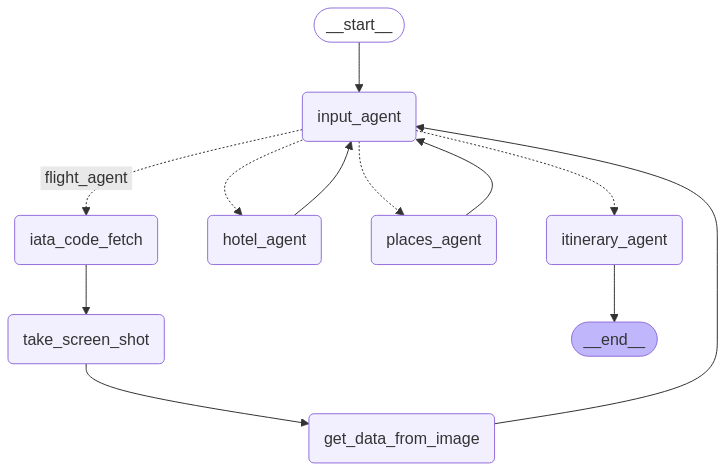

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Test Flow

In [30]:
# testing
final_state = await graph.ainvoke({"messages": ["i want to visit bombay from abu dhabi next week on tuesday for 10 days my budget is 5000 AED give me few itinerary"] })

print(final_state["messages"][-1])

HTTPError: 429 Client Error: Too Many Requests for url: https://travel-guide-api-city-guide-top-places.p.rapidapi.com/check?noqueue=1